## This notebook integrates the output from DADA2, as run on the computing cluster, and our sample data, removing blank samples, merging duplicate DNA extractions, and creating the final phyloseq object that is used in subsequent analyses and notebooks

In [1]:
library(seqinr)
library(reshape)
library(ggplot2)
library(phyloseq)
library(plyr)
library(dplyr)
library(plotly)


Attaching package: ‘plyr’

The following objects are masked from ‘package:reshape’:

    rename, round_any

The following object is masked from ‘package:seqinr’:

    count


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:reshape’:

    rename

The following object is masked from ‘package:seqinr’:

    count

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘plotly’

The following objects are masked from ‘package:plyr’:

    arrange, mutate, rename, summarise

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:reshape’:

    rename

The following object is masked from ‘package:stats’:

    filter

The following object is ma

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

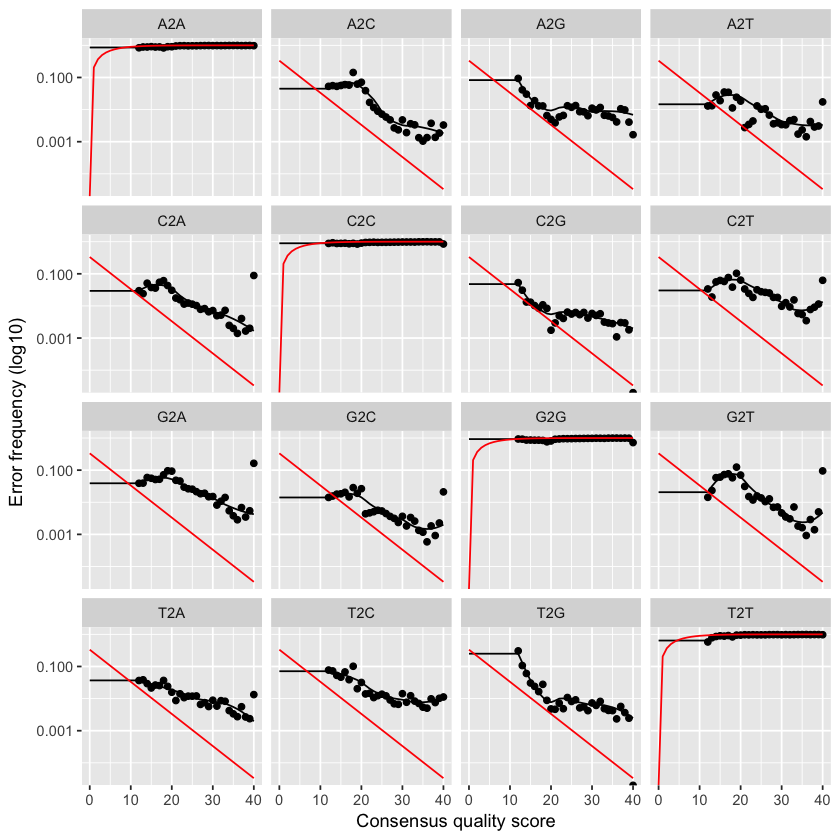

In [2]:
p = readRDS("../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/pErrF.rds")
p
# Not amazing, but fine.

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

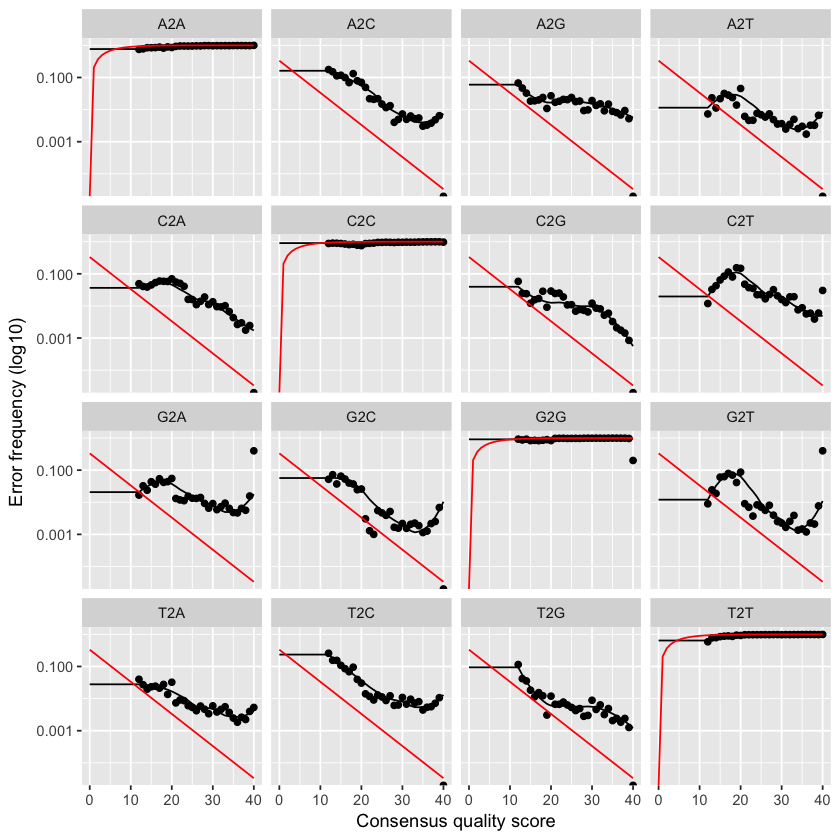

In [3]:
p = readRDS("../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/pErrR.rds")
p
# Not amazing, but ok.

In [4]:
# Check how many sequences were discarded at each point of QC and OTU-picking
Track = data.frame(readRDS("../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/track.rds"))
Track$FractRemain = Track$nonchim/Track$input
head(Track)
median(Track$FractRemain)
mean(Track$nonchim)
# Kept about 70% seqs - that seems fine.

,input,filtered,denoised,tabled,nonchim,FractRemain
15S-NT-19O-1_TGCTCGTA-GATCGTGT_,30789,28398,23021,23021,22907,0.7439995
15S-NT-19O-2_TAGTCTCC-TGCGTACG_,79841,71054,60480,60480,57287,0.7175136
15S-NT-20O-A-1_TAGCAGCT-GACACCGT_,10307,9488,8219,8219,8200,0.7955758
15S-NT-20O-A-2_AACGCTGA-GTCAGATA_,22659,20959,18238,18238,18026,0.7955338
15S-NT-20O-B-1_CGAGCGAC-TAGTGTAG_,31393,28634,25193,25193,24527,0.7812888
15S-NT-20O-B-2_CGAGCGAC-ATCGTACG_,27387,25189,22048,22048,21713,0.7928214


[1] 0.7129354

[1] 22255.73

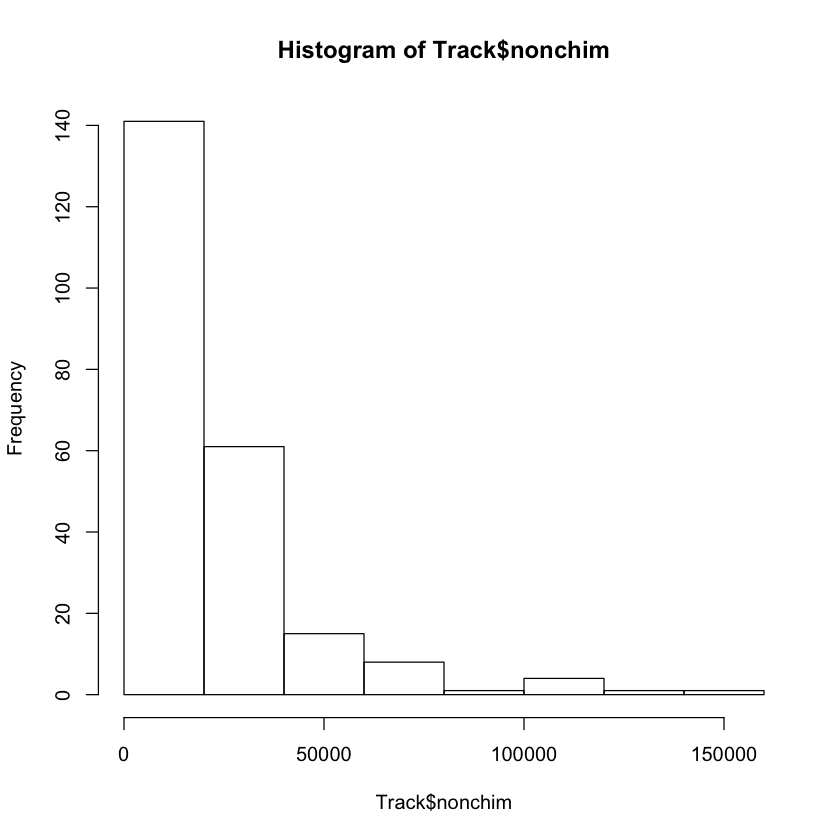

In [6]:
hist(Track$nonchim)
# Distibution of sequence abundances across samples

### Now we'll import the OTU table

In [7]:
fasta = read.fasta(file="../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/DADA2_seqs_nochim.fasta",seqtype = c("DNA"))
SeqNames = sapply(strsplit(getName(fasta),";"), `[`, 1)

In [8]:
OTUtab = t(readRDS("../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/OTUtab.nochim.rds"))
OTUtab = otu_table(OTUtab, taxa_are_rows=TRUE)
SamNames = sample_names(OTUtab)
SamNames = sapply(strsplit(SamNames,"_"), `[`, 1)
sample_names(OTUtab) = SamNames
taxa_names(OTUtab) = SeqNames
head(OTUtab)

,15S-NT-19O-1,15S-NT-19O-2,15S-NT-20O-A-1,15S-NT-20O-A-2,15S-NT-20O-B-1,15S-NT-20O-B-2,15S-NT-21M-1,15S-NT-21M-2,15S-NT-21O-1,15S-NT-21O-2,⋯,Blank-1,Blank-22,Blank-4,Blank-6,Blank-8,Blank,U3M-2,U3O-1,U5O-2,U7M-1
sq1,437,2966,0,0,0,0,1081,645,9,20,⋯,0,0,25,109,67,0,0,0,137,31
sq2,144,295,0,69,167,188,0,0,21,0,⋯,0,0,0,2071,0,0,0,2239,1047,653
sq3,134,916,0,0,0,0,216,160,0,0,⋯,0,0,0,0,0,0,0,0,0,0
sq4,172,278,1156,3143,5205,4069,0,0,0,61,⋯,0,0,0,253,0,0,0,1808,217,235
sq5,22,0,0,0,0,0,0,0,0,0,⋯,0,0,0,279,21,0,0,218,0,51
sq6,1313,1077,0,77,0,0,135,72,527,780,⋯,0,0,0,175,0,0,0,2103,618,1148


In [9]:
# The only re-run blank relevant for this set was B6, so removing B20, and "Blank"
OTUtab = prune_samples(!(sample_names(OTUtab) %in% c("B20","Blank")),OTUtab)

In [10]:
dim(OTUtab)

[1] 20020   230

### Bring in sample data

In [11]:
samdat = sample_data(read.csv("../../../data/Soils_data/WBNPNWT_Soils_2015_Metadata_File_16S.txt",sep="\t",row.names=1))
# Pulling in the sample data

In [12]:
(colnames(OTUtab)) %in% rownames(samdat)
rownames(samdat) %in% (colnames(OTUtab))
# Make sure the data frames are arranged in the same way

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [91] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[106] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[121] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[136] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[151] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[166] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[181] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[196] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[211] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[226] TRUE TRUE TRUE TRUE TRUE

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [91] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[106] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[121] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[136] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[151] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[166] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[181] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[196] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[211] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[226] TRUE TRUE TRUE TRUE TRUE

In [13]:
row.names(samdat)=samdat$Sample_Name
head(samdat)

,Barcodes,Sample_Name,Project_ID,Sample_ID,Site_ID,Replicate,Org_or_Min,Fwd_Primer_Barcode,Rev_Primer_Barcode,Revcomp_Rev_Primer_Barcode,⋯,POPUBAL_BA_per_Ha,BETUPAP_BA_per_Ha,BA_ha,Pct_Conifer_Stems_lar,Pct_Conifer_BA_lar,Median_CBH,Flammable_T_ha,Conifer_CBD,Surface_Severity_Class,Soil_Class
15S-WB-01M-2,GTTGCCAACCAAGCTA,15S-WB-01M-2,WB15,15S-WB-01M,15S-WB-01,2,M,GTTGCCAA,CCAAGCTA,NNNNNNNN,⋯,0,0,19.09115195,100,100,13.05,10.76939299,0.146882317,High,Typic Mesisol
15S-WB-02O-1,GCAATTGGTTCTAAGT,15S-WB-02O-1,WB15,15S-WB-02O,15S-WB-02,1,O,GCAATTGG,TTCTAAGT,NNNNNNNN,⋯,0,0,3.008714394,100,100,2.9,4.050277659,0.186577169,Mixed,Typic Mesisol
15S-WB-02O-2,CGCATGAGACGCATTC,15S-WB-02O-2,WB15,15S-WB-02O,15S-WB-02,2,O,CGCATGAG,ACGCATTC,NNNNNNNN,⋯,0,0,3.008714394,100,100,2.9,4.050277659,0.186577169,Mixed,Typic Mesisol
15S-WB-04M-1,GTCTGCAGACGCGCGT,15S-WB-04M-1,WB15,15S-WB-04M,15S-WB-04,1,M,GTCTGCAG,ACGCGCGT,NNNNNNNN,⋯,0.000132216,0,0.01711373,68.74999996,97.14916035,7.1,0.088382643,0,High,Orthic Gray Luvisol
15S-WB-04M-2,TTATAGCACTTACTCC,15S-WB-04M-2,WB15,15S-WB-04M,15S-WB-04,2,M,TTATAGCA,CTTACTCC,NNNNNNNN,⋯,0.000132216,0,0.01711373,68.74999996,97.14916035,7.1,0.088382643,0,High,Orthic Gray Luvisol
15S-WB-05M-1,CCAACGTTTGCCTACT,15S-WB-05M-1,WB15,15S-WB-05M,15S-WB-05,1,M,CCAACGTT,TGCCTACT,NNNNNNNN,⋯,0,0,30.13538357,96.875,98.67919505,11.1,14.42818448,0.331102875,High,Orthic Gray Luvisol


### Bring in taxonomy

In [14]:
TaxTab = read.table("../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/DADA2_seqs_nochim.pcr.knn.taxonomy",sep="\t", fill=TRUE)
# Gets the taxonomy table separated into the name+size, taxonomy, and two scores.

V1split = read.table(textConnection(as.character(TaxTab$V1)), sep=";",fill=TRUE, header=FALSE)
# Split out the otu ID and count

V2split = read.table(textConnection(as.character(TaxTab$V2)), sep=";",fill=TRUE, header=FALSE)
# Split out the taxonomy and read it as greengenes

In [15]:
TaxTab[,1:2] = V1split
TaxTab[,3:9] = V2split
colnames(TaxTab) = c("OTU","Size","Kingdom","Phylum","Class","Order","Family","Genus","Species")
TaxTabPs = TaxTab[,]
TaxTabPs = as.matrix(TaxTabPs)
row.names(TaxTabPs) = TaxTabPs[,1]
TaxTabPs = TaxTabPs[,3:9]
TaxTabPs = tax_table(TaxTabPs)
head(TaxTabPs)

Warning message in `[<-.data.frame`(`*tmp*`, , 1:2, value = structure(list(V1 = structure(c(1L, :
“provided 3 variables to replace 2 variables”

,Kingdom,Phylum,Class,Order,Family,Genus,Species
sq1,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,,NA
sq2,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,,NA
sq3,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Oxalobacteraceae,Massilia,NA
sq4,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,NA
sq5,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,NA
sq6,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,NA


In [59]:
# Tree for unifrac
#Tree = phy_tree("../OTU_table/Trees/fulltree.tre")

### Putting it all together

In [16]:
ps = phyloseq(OTUtab,samdat,TaxTabPs)
ps2 = ps
# Saving the non-normalized data frame
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 20020 taxa and 230 samples ]
sample_data() Sample Data:       [ 230 samples by 109 sample variables ]
tax_table()   Taxonomy Table:    [ 20020 taxa by 7 taxonomic ranks ]

In [17]:
sample_sums(ps)

15S-NT-19O-1     15S-NT-19O-2   15S-NT-20O-A-1   15S-NT-20O-A-2 
           22907            57287             8200            18026 
  15S-NT-20O-B-1   15S-NT-20O-B-2     15S-NT-21M-1     15S-NT-21M-2 
           24527            21713            20437            10586 
    15S-NT-21O-1     15S-NT-21O-2     15S-NT-22M-1     15S-NT-22M-2 
            9732            14499            12736             6589 
    15S-NT-22O-1     15S-NT-22O-2     15S-NT-23M-1     15S-NT-23M-2 
           19951            14414            12580            14306 
    15S-NT-23O-1     15S-NT-23O-2     15S-NT-24M-1     15S-NT-24M-2 
           37741            26533            23073            20978 
    15S-NT-24O-1     15S-NT-24O-2     15S-NT-25O-1     15S-NT-25O-2 
            9066            25200            41240            22371 
    15S-NT-26O-1     15S-NT-26O-2     15S-NT-27M-1     15S-NT-27M-2 
           18785            11582            15902            26833 
    15S-NT-27O-1     15S-NT-27O-2     15S-NT-28M-1     15S-NT-28M-2 
           17381            24170            26743             7764 
    15S-NT-28O-1     15S-NT-28O-2     15S-NT-29O-1     15S-NT-29O-2 
           17786            12545            14994            10653 
    15S-NT-30M-1     15S-NT-30M-2     15S-NT-30O-1     15S-NT-30O-2 
           24546            30772            11480            18611 
    15S-NT-31M-1     15S-NT-31M-2   15S-NT-31O-A-1   15S-NT-31O-A-2 
           13010             9892            17067            20378 
  15S-NT-31O-B-1   15S-NT-31O-B-2     15S-NT-32O-1     15S-NT-32O-2 
            9140             9416             7252             8115 
    15S-NT-33M-1     15S-NT-33M-2     15S-NT-33O-1     15S-NT-33O-2 
           63248            10460             8649            11002 
    15S-NT-34M-1     15S-NT-34M-2     15S-NT-34O-1     15S-NT-34O-2 
            6010             9773            24709            45232 
    15S-NT-35O-1     15S-NT-35O-2     15S-NT-36O-1     15S-NT-36O-2 
           10400            11785            10230            34114 
    15S-NT-38M-1     15S-NT-38M-2     15S-NT-38O-1     15S-NT-38O-2 
           14084            15682            34957            79688 
    15S-NT-39M-1     15S-NT-39M-2     15S-NT-39O-1     15S-NT-39O-2 
           15205            14984             4904            14900 
    15S-NT-40M-1     15S-NT-40M-2     15S-NT-40O-1     15S-NT-40O-2 
           10671            18962            19552           101225 
    15S-NT-41M-1     15S-NT-41M-2     15S-NT-41O-1     15S-NT-41O-2 
          106038            59919            34842            24842 
    15S-NT-42M-1     15S-NT-42M-2     15S-NT-42O-1     15S-NT-42O-2 
           67091            19230             7273             6395 
    15S-NT-43M-1     15S-NT-43M-2     15S-NT-43O-1     15S-NT-43O-2 
            7823            10913             4377             8824 
    15S-NT-44M-1     15S-NT-44M-2     15S-NT-44O-1     15S-NT-44O-2 
            7122            22429            13550            22524 
    15S-NT-45O-1     15S-NT-45O-2     15S-NT-46M-1     15S-NT-46M-2 
           27526            13162            22821             9610 
    15S-NT-47M-1     15S-NT-47M-2     15S-NT-47O-1     15S-NT-47O-2 
           12040             8291            16460            16600 
    15S-NT-48O-1     15S-NT-48O-2     15S-NT-49M-1     15S-NT-49M-2 
           14904             9706             7043            11624 
    15S-NT-49O-1     15S-NT-49O-2     15S-NT-50O-1     15S-NT-50O-2 
           11329            41234             6470             2742 
    15S-NT-51O-1     15S-NT-51O-2     15S-NT-52O-1     15S-NT-52O-2 
           10421             7052             7873             8140 
   15S-NT-U06O-1    15S-NT-U06O-2    15S-NT-U07M-1    15S-NT-U07M-2 
            5771            16012             3263            10585 
   15S-NT-U07O-1    15S-NT-U07O-2    15S-NT-U08M-1    15S-NT-U08M-2 
           10968             9752            12469            14724 
  

In [20]:
df=data.frame(Names=row.names(data.frame(sample_sums(ps))),Sums=sample_sums(ps))
df = df %>%
    arrange(Sums)
df
#write.csv(df,"SampleSums16S.csv")
# Check abundances of samples

Names,Sums
15S-WB-05M-2,0
15S-WB-05O-2,0
15S-WB-08M-1,0
5M-2,0
7O-1,0
U3M-2,0
15S-WB-07O-1,19
Blank-1,20
15S-WB-U03M-2,23
Blank-22,86


[1] 5156440

[1] 0

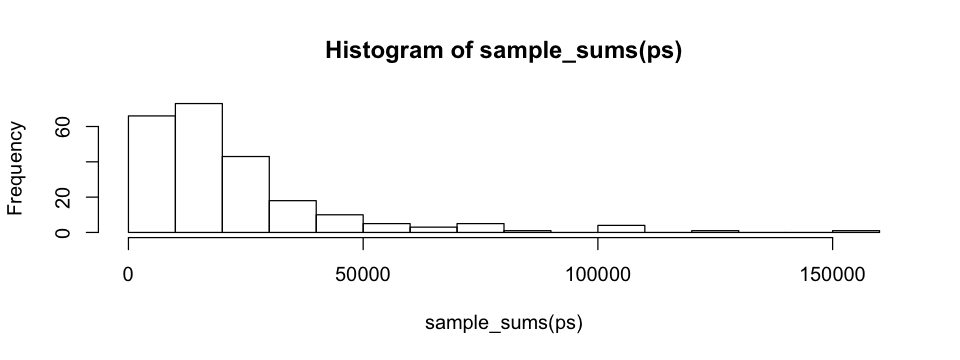

In [21]:
options(repr.plot.width=8, repr.plot.height=3)
sum(sample_sums(ps))
min(sample_sums(ps))
hist(sample_sums(ps), breaks=20)
# Distribution of sequences per sample

In [22]:
ps.merged = merge_samples(ps, "Sample_ID")
# Merging the in-lab DNA extraction samples
# This sums the OTUs for each sample ID, and averages the sample data
# That's an issue for the non-numeric sample data, so we have to add it back in.
# The code below is probably inefficient, but it works correctly.

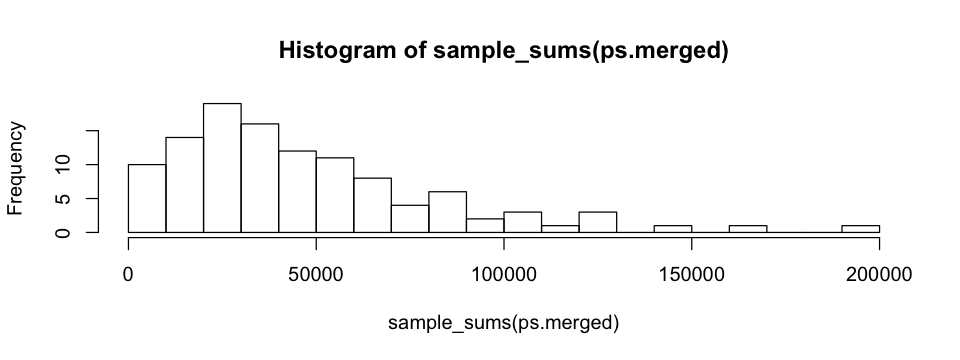

In [23]:
options(repr.plot.width=8, repr.plot.height=3)
hist(sample_sums(ps.merged), breaks=20)

In [24]:
names=colnames(sample_data(ps))
notcommonnames = c('Sample_Name','Replicate','Project_ID','Fwd_Primer_Barcode','Rev_Primer_Barcode','Revcomp_Rev_Primer_Barcode')
commonnames = names[(names %in% notcommonnames)]
common_sample_data = sample_data(ps)[ , -which(names(sample_data(ps)) %in% commonnames)]
commonrownames=row.names(sample_data(ps.merged))
common_sample_data2 = common_sample_data[which(common_sample_data$Sample_ID %in% commonrownames),]
common_sample_data2 = common_sample_data2[!duplicated(common_sample_data2$Sample_ID), ]
row.names(common_sample_data2) = common_sample_data2$Sample_ID
sample_data(ps.merged)=common_sample_data2

# Renaming it all
ps=ps.merged

In [25]:
# Importing the dataset
FactorTable = read.csv("../../../data/Soils_data/SamDat.txt",sep="\t",header=TRUE)
# Importing a dataframe with all the factors and whether or not they should be numeric
# And what set of data they belong to

FactorTable = FactorTable[(FactorTable$Factors %in% colnames(sample_data(ps))),]

In [26]:
for (i in colnames(sample_data(ps))[colnames(sample_data(ps)) %in%  FactorTable$Factors ]) {
        if(FactorTable$Class[FactorTable$Factors==i]=="num"){
            sample_data(ps)[,i] = as.numeric(paste(data.frame(sample_data(ps.merged)[,i])[,1]))
        }
    }
# No real need to do this for full ps, as won't really be doing stats on raw data

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, e

In [27]:
sample_data(ps)$Severity_Class = factor(sample_data(ps)$Severity_Class, c("Unburned","Low","Moderate","High"))
# Setting severity class as a factor

In [28]:
cutoff = 1000
# Based on abundance in blanks

ps = prune_samples(sample_sums(ps)>=cutoff, ps)
# This results in one blank remaining - possibly one sample contaminated?
ps = subset_samples(ps, Sample_ID!="Blank-6")
# Removing that sample

ps.norm = transform_sample_counts(ps, function(x) (x / sum(x)))
ps.hell = transform_sample_counts(ps, function(x) (x / sum(x))^0.5)
# Hellinger Transformation: "Particularly suited to species abundance data, 
    # this transformation gives low weights to variables with low counts and many zeros. 
    # The transformation itself comprises dividing each value in a data matrix by its row sum, 
    # and taking the square root of the quotient.
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 20020 taxa and 102 samples ]
sample_data() Sample Data:       [ 102 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 20020 taxa by 7 taxonomic ranks ]

In [30]:
ps = subset_taxa(ps,Kingdom != "unknown")
# Remove taxa that don't have any decent taxonomic ID - just a few dozen low abundance taxa
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19988 taxa and 102 samples ]
sample_data() Sample Data:       [ 102 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 19988 taxa by 7 taxonomic ranks ]

In [34]:
#saveRDS(ps, file="../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/ps.merged")
# Saving the final phyloseq object, which will be used for all subsequent analyses.

### This is our final ps object